[Этот ноутбук в колабе](https://colab.research.google.com/drive/1RsZvw4KBGn5U5Aj5Ak7OG2pHx6z1OSlF)

Введение:

* [Про тензоры в pytorch](https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/tensor_tutorial.ipynb)
* [Про автоматическое дифференцирование и что такое .backwards()](https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/autograd_tutorial.ipynb)

### Генерируем датасет

In [1]:
NUM_FEATURES = 2
NUM_SAMPLES = 1000

In [2]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples = NUM_SAMPLES,
                           n_features = NUM_FEATURES,
                           n_informative = NUM_FEATURES,
                           n_redundant = 0,
                           n_classes = 2,
                           n_clusters_per_class = 1,
                           class_sep = 0.75,
                           random_state = 123)

In [3]:
len(X)

1000

In [4]:
X[0]

array([-1.12038312, -0.78656935])

In [7]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

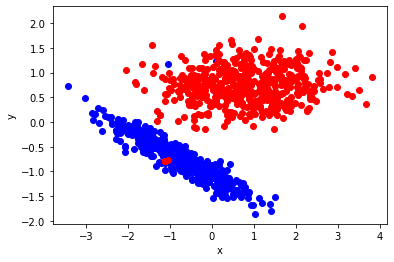

In [8]:
y = y.reshape(-1, 1)

ones = np.where(y == 1)   # индексы объектов класса '1'
zeros = np.where(y == 0)  # индексы объектов класса '0'

plt.xlabel('x')
plt.ylabel('y')
plt.plot(X[ones, 0], X[ones, 1], 'ob',
         X[zeros, 0], X[zeros, 1], 'or');

### Зададим нейронку

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [11]:
class Net(nn.Module):

    def __init__(self):
        # в ините описываются слои; NB: это просто их описание, порядок -- не важен
        # кроме того, здесь описывается только линейная часть, а нелинейные операции -- в методе forward
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 10)
        self.fc2 = nn.Linear(10, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x


net = Net()
print(net)

Net(
  (fc1): Linear(in_features=2, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=1, bias=True)
)


In [12]:
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

4
torch.Size([10, 2])


In [13]:
params[0] # случайно инициализированные параметры

Parameter containing:
tensor([[ 0.6073, -0.6408],
        [-0.2685,  0.4454],
        [ 0.4543,  0.4758],
        [ 0.5100,  0.3468],
        [ 0.6583, -0.6199],
        [-0.6146,  0.5574],
        [ 0.2010,  0.5392],
        [-0.0938,  0.1638],
        [ 0.5042, -0.0934],
        [-0.2945,  0.4538]], requires_grad=True)

Прогоняем один объект:

In [14]:
inp = torch.tensor(X[0]).float().unsqueeze(0)
inp

tensor([[-1.1204, -0.7866]])

Output для одного объекта (без обучения):

In [15]:
out = net(inp)
print(out)

tensor([[0.6007]], grad_fn=<SigmoidBackward>)


### Определяем функцию потерь

Функция потерь:

In [16]:
# бинарная кросс-энтропия == логарифм вероятности положительнго класса
criterion = nn.BCELoss()

Истинная метка:

In [17]:
target = torch.tensor(y[0]).float()
target

tensor([1.])

Признаки для первого объекта:

In [22]:
inp

tensor([[-1.1204, -0.7866]])

Получение значения функции потерь для одного объекта:

In [19]:
output = net(inp)
print(output)
loss = criterion(output, target)
print(loss)

tensor([[0.6007]], grad_fn=<SigmoidBackward>)
tensor(0.5097, grad_fn=<BinaryCrossEntropyBackward>)


/home/maryszmary/.local/share/virtualenvs/NLP_DPO_2020-U6tis9ju/lib/python3.6/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Постмотрим на функции, записанные за лоссом для получения градиентов.

In [20]:
print(loss.grad_fn)  # BCELoss
print(loss.grad_fn.next_functions[0][0])  # Sigmoid

### Backprop

Посчитаем градиенты:

In [21]:
net.zero_grad()     # zeroes the gradient buffers of all parameters

print('conv1.bias.grad before backward')
print(net.fc1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.fc1.bias.grad)

conv1.bias.grad before backward
None
conv1.bias.grad after backward
tensor([ 0.0000, -0.0492,  0.0000,  0.0000, -0.1084,  0.0000,  0.0000, -0.1130,
         0.0000,  0.0000])


А теперь сделаем опитимизацию для одного объекта:

In [22]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output = net(inp)
loss = criterion(output, target)
loss.backward()
optimizer.step()    # Does the update

In [23]:
print(loss)

tensor(0.5097, grad_fn=<BinaryCrossEntropyBackward>)


Попробуем обучить нейросеть на всём:

In [26]:
in_data = torch.tensor(X).float()

In [27]:
out_data = torch.tensor(y).float()

In [28]:
for i in range(250): # кол-во эпох
    optimizer.zero_grad()
    output = net(in_data)
    loss = criterion(output, out_data)
    loss.backward()
    optimizer.step()
    if i % 50 == 0:
        print(loss)

tensor(0.6668, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5634, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4938, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4391, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.3927, grad_fn=<BinaryCrossEntropyBackward>)
